# Optimization hands-on session: the Heat Equation

To test the different optimization techniques, we will try to optimize an explicit finite different scheme (with a Jacobi iteration method) to solve the Heat equation:

\begin{equation*}\partial_t \phi = \alpha \left[\partial^2_{x^2}\phi + \partial^2_{y^2} \phi\right], \text{ for } x \in [0, L_x], \quad y \in [0, L_y], \quad t \geq 0.\end{equation*}

We will use a 3-points central difference method, with a 2nd-order accuracy; it means that $\phi_{i,j}$ is updated at time $t = t_{n+1} = (n+1)\Delta t$ following:

\begin{eqnarray*}\phi_{i,j}^{n+1} & = & \phi_{i,j}^{n} + \alpha\frac{\Delta t}{\Delta x \Delta y}\left[\left(\phi_{i+1,j}^n - 2 \phi_{i,j}^n + \phi_{i-1,j}^n\right) +  \left(\phi_{i,j+1}^n - 2 \phi_{i,j}^n + \phi_{i,j-1}^n\right)\right] \\
 & = & R_2 \phi_{i,j}^n + R\left[\phi_{i+1,j}^n + \phi_{i-1,j}^n + \phi_{i,j+1}^n + \phi_{i,j-1}^n\right],\end{eqnarray*}
 
 with $R = \alpha \Delta t/\Delta x/\Delta y$, and $R_2 = 1 - 4R$. For the sake of simplicity, we will consider $\alpha = L_x = L_y = 1$.

## Python version

First, let's try a normal Python version to see how it is implemented and what it returns:

In [1]:
%matplotlib inline

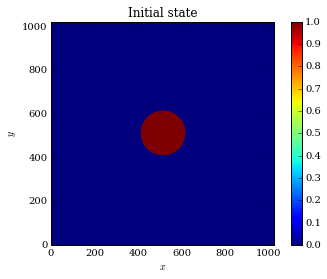

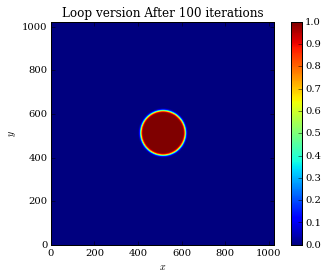

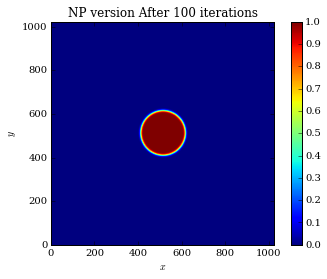

In [2]:
import numpy as np
import pylab as pl


# Jacobi function
def jacobi(a, nxi, nyi):
    for i in xrange(1,nxi-1):
        for j in xrange(1,nyi-1):
            anew[i,j] = 0.5*a[i,j] + 0.125*(a[i-1,j] + a[i+1,j] \
                                   + a[i,j-1] + a[i,j+1])
    return anew


def np_jacobi( a ):
    a_ijp1 = a[1:-2,1:-2]
    a_ij   = a[1:-1,1:-1]
    a_im1j = a[0:-2,1:-1]
    a_ip1j = a[2:,1:-1]
    a_ijm1 = a[1:-1,0:-2]
    a_ijp1 = a[1:-1,2:]
    
    a[1:-1,1:-1] = 0.5*a_ij + 0.125*( a_im1j + a_ip1j + a_ijm1 + a_ijp1 ) 
    return a
    
# Solver: iterate and call the Jacobi function
def solveHeat(a, anew, nxi, nyi, niter):
    i = 1
    while (i < niter):
        anew = jacobi(a,nxi,nyi)
        a = anew.copy()
        i += 1
    return anew

# Solver: iterate and call the Jacobi function
def np_solveHeat(a, anew, nxi, nyi, niter):
    i = 1
    while (i < niter):
        anew = np_jacobi(a)
        #a = anew.copy()
        i += 1
    return anew

# Problem initialization: hot disc in a cold medium
def initProblem(a, nxi, nyi):
    for i in xrange(nxi):
        for j in xrange(nyi):
            indx = (i - nxi/2)/(nxi/10.)
            indy = (j - nyi/2)/(nyi/10.)
            if (indx**2 + indy**2) <= 1:
                a[i,j] = 1.
    return a

def plotResult(a, title='', *args, **kwargs):
    fig = pl.figure()
    pl.imshow(a, origin='lower')
    pl.title(title)
    pl.xlabel(r'$x$')
    pl.ylabel(r'$y$')
    pl.colorbar()
    return fig
     
# Parameters of the problem
niter = 100
nx = 1024
ny = 1024
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew = a.copy()

# Plot and solve the problem
fig1 = plotResult(a, 'Initial state')
anew = solveHeat(a, anew, nx, ny, niter)
fig2 = plotResult(anew, 'Loop version After %d iterations' %niter)


# Parameters of the problem
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew2 = a.copy()
anew2 = np_solveHeat(a, anew2, nx, ny, niter)
fig2 = plotResult(anew2, 'NP version After %d iterations' %niter)

Allright, and if we time it:

In [3]:
niter = 10
nx = 128
ny = 128
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew = a.copy()
%timeit solveHeat(a, anew, nx, ny, niter)

10 loops, best of 3: 170 ms per loop


In [4]:
%timeit np_solveHeat(a,anew,nx,ny,niter)

1000 loops, best of 3: 1.42 ms per loop


Can we do better?

## Cython version

In [5]:
%load_ext cythonmagic

The Cython magic has been moved to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


### Hints:
- don't forget to type your variables
- does everything need to be defined as pure Python function?
- are there any directives you can use?

In [6]:
%%cython
# Make your imports

def jacobi(a, nxi, nyi):
    for i in xrange(1,nxi-1):
        for j in xrange(1,nyi-1):
            anew[i,j] = 0.5*a[i,j] + 0.125*(a[i-1,j] + a[i+1,j] \
                                   + a[i,j-1] + a[i,j+1])
    return anew

def solveHeat(a, anew, nxi, nyi, niter):
    i = 1
    while (i < niter):
        anew = jacobi(a, nxi, nyi)
        a = anew.copy()
        i += 1
    return anew


Error compiling Cython file:
------------------------------------------------------------
...
# Make your imports

def jacobi(a, nxi, nyi):
    for i in xrange(1,nxi-1):
        for j in xrange(1,nyi-1):
            anew[i,j] = 0.5*a[i,j] + 0.125*(a[i-1,j] + a[i+1,j] \
               ^
------------------------------------------------------------

/Users/kosack/.ipython/cython/_cython_magic_18efc1c402a297964fd8816658dd76aa.pyx:6:16: undeclared name not builtin: anew


In [ ]:
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew = a.copy()
%timeit solveHeatCython(a, anew, nx, ny, niter)

## F2py version

### Hints:
- don't forget that indices start at 1 in Fortran
- the 'while' instruction has the form `do while (condition)`

In [ ]:
%%file heat.f90
module heat
contains
  function jacobiFortran([input variables]) result([output variables])
    implicit none

    ! Declarations
    
    ! Do stuff

  end function jacobiFortran

  subroutine solveHeatFortran([input variables])
    implicit none

    ! Declarations
    
    ! Do stuff

  end subroutine solveHeatFortran
end module heat

In [ ]:
!f2py -c -m heat heat.f90

In [ ]:
from heat import heat

a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
# Don't forget to order your arrays in a Fortran-contiguous way
aF   = a.copy(order='F')
anew = aF.copy(order='F')
%timeit heat.solveheatfortran(aF, anew, niter)

## Numba version

In [ ]:
# Make your imports

def jacobi(a, nxi, nyi):
    for i in xrange(1,nxi-1):
        for j in xrange(1,nyi-1):
            anew[i,j] = 0.5*a[i,j] + 0.125*(a[i-1,j] + a[i+1,j] \
                                   + a[i,j-1] + a[i,j+1])
    return anew

def solveHeat(a, anew, nxi, nyi, niter):
    i = 1
    while (i < niter):
        anew = jacobi(a, nxi, nyi)
        a = anew.copy()
        i += 1
    return anew

In [ ]:
a = np.zeros((nx,ny))
a = initProblem(a, nx, ny)
anew = a.copy()
%timeit solveHeatNumba(a, anew, nx, ny, niter)

# Concurrent & parallel computing hands-on session: Monte Carlo Pi

We will compute the approximate value of $\pi$ with a Monte Carlo integration algorithm. Each point $(x,y)$ in a list of random points within a "unit" square is evaluated using the function:

$$f(x,y) = (x^2 + y^2 < 1) \quad ? \quad 1 \quad : \quad 0$$

The points are then summed. The approximate value of $\pi$ can then be calculated by multiplying four times the volume of the square with the mean value for $f(x,y)$.

The code itself is quite simple, and the algorithm is *embarassingly* parallel because each $f(x,y)$ calculation can be performed independently. Besides, the algorithm uses a sum reduction, which makes it interesting.

## Python version

In [ ]:
import numpy as np

def compPi(nelmt=int(1e6)):
    # Initialize points coordinates (x,y)
    x = np.random.random(nelmt)
    y = np.random.random(nelmt)
    temp = np.zeros(nelmt)
    # Evaluation of each point with f 
    for i in xrange(nelmt):
        radSq = x[i]*x[i] + y[i]*y[i]
        temp[i] = 1 if (radSq < 1) else 0
    
    sumA = 0.
    for i in xrange(nelmt):
        sumA += temp[i]

    return 4*sumA/nelmt

%timeit compPi()

## `multiprocessing` version

For the multiprocessing version, the simplest thing to do is to distribute evenly the work among the processes.

### Hints:
- you can use a `pool` (what do you need to do so?)

In [ ]:
import multiprocessing as mp

def piPool(nelmt=int(1e6)):
    # Create your pool
    # Distribute the work among processes
    # Return a result

%timeit piPool()

## `mpi4py` version

The same can be done with MPI.

### Hints:
- each process has to compute part of the result
- a reduction must be made to retrieve the final result

In [ ]:
%%file piparallel.py
#!/usr/bin/env python
import os
from mpi4py import MPI
import numpy as np

def compPi(nelmt=int(1e6)):
    x = np.random.random(nelmt)
    y = np.random.random(nelmt)
    temp = np.zeros(nelmt)
    for i in xrange(nelmt):
        radSq = x[i]*x[i] + y[i]*y[i]
        temp[i] = 1 if (radSq < 1) else 0
    
    sumA = 0.
    for i in xrange(nelmt):
        sumA += temp[i]

    return 4*sumA/nelmt

def piMPI(nelmt=int(1e6)):
    # Communicator initalization
    
    t1 = MPI.Wtime()
    # Compute pi
    # Perform a reduction
    t2 = MPI.Wtime()
    if rank == 0: print("Elapsed time: %9.8f s" %(t2 - t1))
    return pi

if __name__ == '__main__':
    pi = piMPI()

In [ ]:
%%bash
chmod +x piparallel.py
mpirun -np 4 ./piparallel.py